In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [7]:
data_path = r'data/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [8]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

# Parameter experiments

## Running experiments

Define parameters:

In [9]:
random_seed = 1038
scaling = True
oversampling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Define train and test splits:

In [10]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)

Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [11]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

Run the experiments, save the experiment results to csv and pickle:

In [12]:
models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

df_param.to_csv(r'results/fertility_params_experiments.csv', index=False)

with open(r'results/fertility_lists_experiments.pickle', 'wb') as handle:
    pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 75...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 30...
Loss did not go down for 10 iterations. Stopping training at iteration 30...
Loss did not go down for 10 iterations. Stopping training at iteration 45...
Loss did not go down for 10 iterations. Stopping training at iteration 519...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 16...
Loss did not go down for 10 iterations. Stopping training at iteration 36..

/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


Loss did not go down for 10 iterations. Stopping training at iteration 34...
Loss did not go down for 10 iterations. Stopping training at iteration 33...
Loss did not go down for 10 iterations. Stopping training at iteration 47...
Loss did not go down for 10 iterations. Stopping training at iteration 80...
Loss did not go down for 10 iterations. Stopping training at iteration 81...
Loss did not go down for 10 iterations. Stopping training at iteration 46...
Loss did not go down for 10 iterations. Stopping training at iteration 56...
Loss did not go down for 10 iterations. Stopping training at iteration 62...
Loss did not go down for 10 iterations. Stopping training at iteration 75...
Loss did not go down for 10 iterations. Stopping training at iteration 87...
Loss did not go down for 10 iterations. Stopping training at iteration 25...
Loss did not go down for 10 iterations. Stopping training at iteration 23...
Loss did not go down for 10 iterations. Stopping training at iteration 29...

/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


As a punishment we return a model with randomly initialized weights.
Loss did not go down for 10 iterations. Stopping training at iteration 41...
Loss did not go down for 10 iterations. Stopping training at iteration 66...


/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow e

As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
Loss did not go down for 10 iterations. Stopping training at iteration 51...
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.


/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow e

Loss did not go down for 10 iterations. Stopping training at iteration 21...
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.

As a punishment we return a model with randomly initialized weights.As a punishment we return a model with randomly initialized weights.

As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return

/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow e

As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model 

/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/david/TU/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value enco

Loss did not go down for 10 iterations. Stopping training at iteration 130...
Loss did not go down for 10 iterations. Stopping training at iteration 132...
Loss did not go down for 10 iterations. Stopping training at iteration 126...
Loss did not go down for 10 iterations. Stopping training at iteration 142...
Loss did not go down for 10 iterations. Stopping training at iteration 168...
Loss did not go down for 10 iterations. Stopping training at iteration 29...
Loss did not go down for 10 iterations. Stopping training at iteration 45...
Loss did not go down for 10 iterations. Stopping training at iteration 45...
Loss did not go down for 10 iterations. Stopping training at iteration 113...
Loss did not go down for 10 iterations. Stopping training at iteration 187...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteratio

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [13]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

results_df.to_csv("results/fertility_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 57...
Evaluation metrics:


array([[0.94444444, 0.05555556],
       [1.        , 0.        ]])

acc: 0.85
balanced_acc: 0.4722222222222222

Macro-averaged precision: 0.4473684210526316
Macro-averaged recall: 0.4722222222222222
Macro-averaged f-score: 0.4594594594594595
Macro-averaged support: None


/tmp/ipykernel_23533/2726838548.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 181...
Evaluation metrics:


array([[0.5, 0.5],
       [1. , 0. ]])

acc: 0.45
balanced_acc: 0.25

Macro-averaged precision: 0.4090909090909091
Macro-averaged recall: 0.25
Macro-averaged f-score: 0.31034482758620685
Macro-averaged support: None


/tmp/ipykernel_23533/2726838548.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 308...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None


/tmp/ipykernel_23533/2726838548.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 47...
Evaluation metrics:


array([[0.72222222, 0.27777778],
       [1.        , 0.        ]])

acc: 0.65
balanced_acc: 0.3611111111111111

Macro-averaged precision: 0.43333333333333335
Macro-averaged recall: 0.3611111111111111
Macro-averaged f-score: 0.39393939393939387
Macro-averaged support: None


/tmp/ipykernel_23533/2726838548.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 159...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None


/tmp/ipykernel_23533/2726838548.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


## Analysis

In [14]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['diverged'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

accuracy_threshold = df_param['test_score_mean'].max() * 0.5

In [15]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'diverged']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [16]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

vg_cols = [c for c in model_lists_df.columns if 'vanishing_gradients_' in c]
model_lists_df[f'vanishing_gradients'] = pd.Series(model_lists_df[vg_cols].values.tolist())
model_lists_df[f'vanishing_gradients'] = model_lists_df[f'vanishing_gradients'].apply(lambda x: sum(x))

In [17]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [18]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [19]:
max_accuracies_ids = df_param[df_param.any_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [20]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

In [21]:
color = [(127,201,127),(190,174,212),(253,192,134),(56,108,176),(255,255,153)]
for i, rgb in enumerate(color):
    r, g, b = rgb
    color[i] = r/255.0, g/255.0, b/255.0

from matplotlib.colors import ListedColormap
cmap = ListedColormap([color[3], color[2]])

### Sigmoid vs RELU

In [22]:
def get_specific_table(model_lists_melted_df, col, accuracy_threshold):
    df = model_lists_melted_df[model_lists_melted_df.metric_name.str.contains(col)].copy()
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    df.loc[:, 'cv'] = df.metric_name.str.extract(r'.*_cv(\d)').astype(int)
    df.loc[:, 'test_score_cv'] = df.apply(lambda x: x.test_score[x.cv], axis=1)
    df.loc[:, 'converged_cv'] = df.apply(lambda x: x.converged[x.cv], axis=1)

    df = df[(df.test_score_cv > accuracy_threshold) & df.converged_cv].copy()

    both_models_converged = pd.DataFrame(df.groupby(['model_short']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')

    return df

#### Fitting times

In [23]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time', accuracy_threshold=accuracy_threshold)

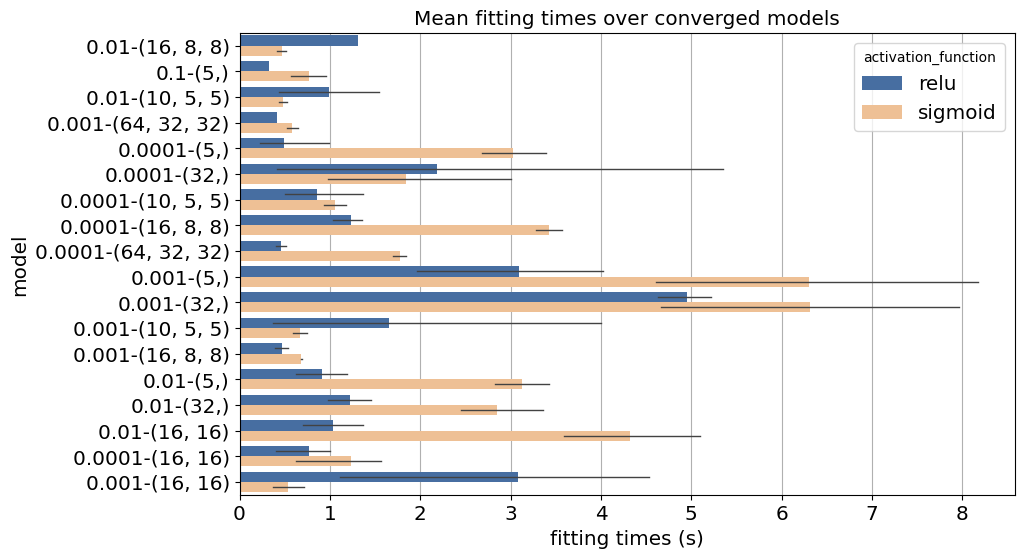

In [24]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")

In [25]:
max_accuracies_models.model.unique()

array(['MLP-relu-0.01-(5,)', 'MLP-sigmoid-0.01-(5,)',
       'MLP-relu-0.01-(10, 5, 5)', 'MLP-sigmoid-0.5-(10, 5, 5)',
       'MLP-relu-0.001-(16, 8, 8)', 'MLP-sigmoid-0.5-(16, 8, 8)',
       'MLP-relu-0.001-(16, 16)', 'MLP-sigmoid-0.0001-(16, 16)',
       'MLP-relu-0.01-(32,)', 'MLP-sigmoid-0.001-(32,)',
       'MLP-relu-0.0001-(64, 32, 32)', 'MLP-sigmoid-0.01-(64, 32, 32)'],
      dtype=object)

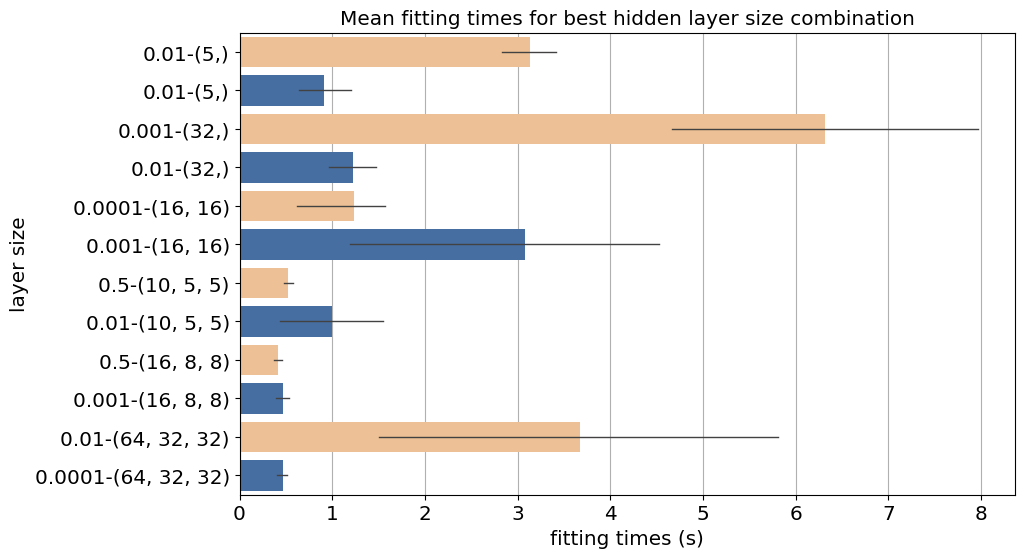

In [26]:
_, ax = plt.subplots(figsize=(10, 6))
df_fit_times_sorted = df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.unique())].copy()
df_fit_times_sorted['s2'] = df_fit_times_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_fit_times_sorted['s3'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_fit_times_sorted['s1'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_fit_times_sorted = df_fit_times_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_fit_times_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean fitting times for best model for each architecture', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Performance

In [27]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score', accuracy_threshold=accuracy_threshold)

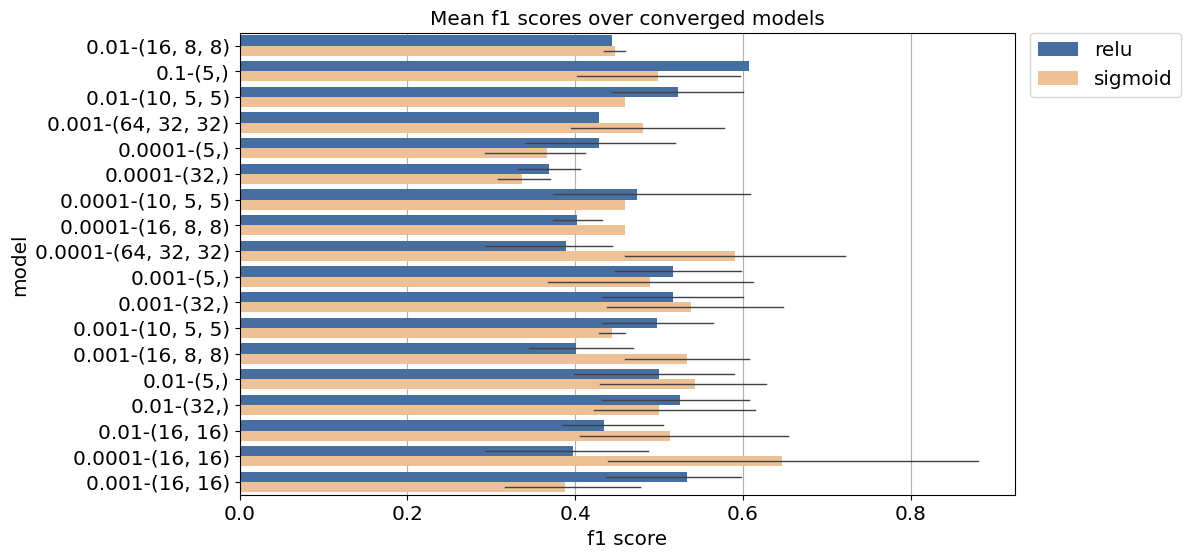

In [28]:
_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

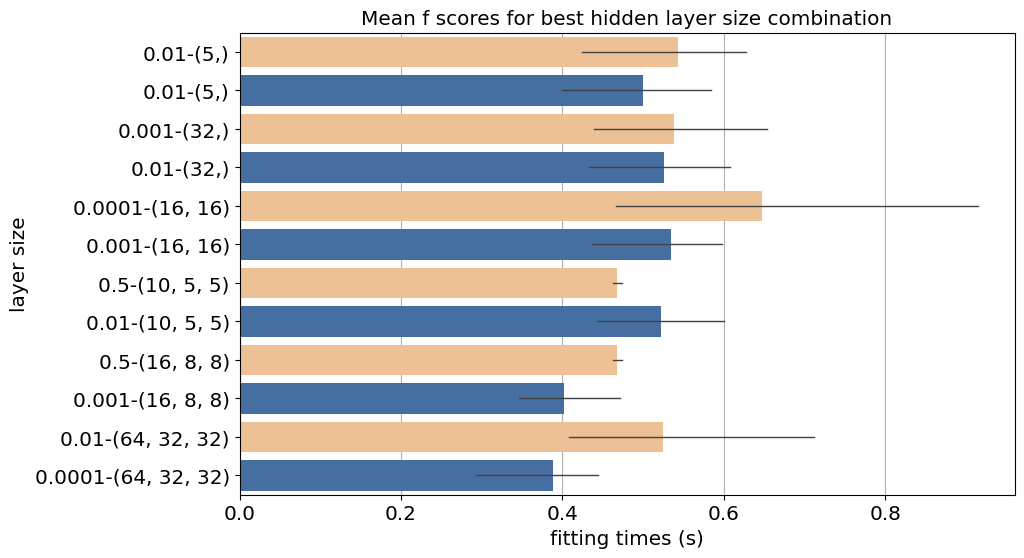

In [29]:
_, ax = plt.subplots(figsize=(10, 6))
df_test_scores_sorted = df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.unique())].copy()
df_test_scores_sorted['s2'] = df_test_scores_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_test_scores_sorted['s3'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_test_scores_sorted['s1'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_test_scores_sorted = df_test_scores_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_test_scores_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean f scores for best hidden layer size combination', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Convergence and vanishing gradients

Looking at gradients where accuracy is bad although training was not interrupted:

In [30]:
model_lists_df[model_lists_df[f'vanishing_gradients'] > 0]

,model,test_score,fit_time,score_time,converged,validation_losses,training_losses,gradients,converged_num,diverged,...,validation_losses_cv3,validation_losses_cv4,vanishing_gradients_cv0,vanishing_gradients_cv1,vanishing_gradients_cv2,vanishing_gradients_cv3,vanishing_gradients_cv4,vanishing_gradients,all_converged,any_converged
0,"MLP-relu-0.0001-(5,)","[0.375, 0.2, 0.30666666666666664, 0.4666666666...","[0.2761650085449219, 0.23776674270629883, 0.23...","[0.005131244659423828, 0.0033278465270996094, ...","[True, True, True, True, True]","[[0.680549601153257, 0.6803739588282192, 0.680...","[[0.6957197868726508, 0.6955154271472882, 0.69...","[{0: [-1.889609500617594e-19, 3.63207727782644...",5,0,...,"[0.746217724347842, 0.7450821181322912, 0.7440...","[0.6964642721741654, 0.696163001915135, 0.6958...",False,True,False,False,False,1,True,True
2,"MLP-relu-0.0001-(16, 16)","[0.23273657289002558, 0.29292929292929293, 0.4...","[1.3361036777496338, 1.0778584480285645, 0.840...","[0.0029675960540771484, 0.0034945011138916016,...","[True, True, True, True, True]","[[0.7764021507180614, 0.7682081193043214, 0.76...","[[0.7223105455817824, 0.7176351275739158, 0.71...","[{0: [9.476620684818728e-19, -4.73355287220059...",5,0,...,"[0.6701924333874334, 0.6708914705228085, 0.671...","[0.6985844113727653, 0.6973570269904132, 0.696...",True,False,False,True,False,2,True,True
3,"MLP-relu-0.0001-(10, 5, 5)","[0.375, 0.2857142857142857, 0.3732193732193732...","[0.6908776760101318, 1.4080491065979004, 1.591...","[0.0031032562255859375, 0.0034418106079101562,...","[True, True, True, True, True]","[[0.7040274242130963, 0.7016491273071167, 0.69...","[[0.7480244237724989, 0.7443788011948386, 0.74...","[{0: [6.195053770569853e-18, -1.26890375686964...",5,0,...,"[0.7372143562837615, 0.7359008027843877, 0.734...","[0.6774024868000208, 0.6772772494748347, 0.677...",False,True,False,False,False,1,True,True
4,"MLP-relu-0.0001-(16, 8, 8)","[0.375, 0.2857142857142857, 0.4505494505494505...","[0.929255485534668, 1.370638132095337, 1.31190...","[0.0045664310455322266, 0.003462076187133789, ...","[True, True, True, True, True]","[[0.7489754884450307, 0.7333115566295849, 0.71...","[[0.861672418966397, 0.84000512242708, 0.82057...","[{0: [-4.83242884320419e-18, -9.75975562767755...",5,0,...,"[1.0446480943089806, 1.0057198267714167, 0.970...","[0.8251384212128743, 0.8109022824411302, 0.798...",False,True,False,False,False,1,True,True
5,"MLP-relu-0.0001-(64, 32, 32)","[0.19999999999999998, 0.29292929292929293, 0.0...","[0.48161768913269043, 0.5101499557495117, 0.47...","[0.003074169158935547, 0.003709077835083008, 0...","[True, True, True, True, True]","[[0.689605501542005, 0.6894910675097087, 0.689...","[[0.6965500329154958, 0.6965121586535246, 0.69...","[{0: [5.04819536092888e-18, 1.5267768874258764...",5,0,...,"[0.768337187064562, 0.7687728012305167, 0.7689...","[0.6876931932047788, 0.6877471924041946, 0.687...",True,False,True,False,False,2,True,True
6,"MLP-relu-0.001-(5,)","[0.25925925925925924, 0.6415770609318996, 0.53...","[4.251173496246338, 3.048851728439331, 3.99002...","[0.0033032894134521484, 0.004629850387573242, ...","[True, True, True, True, True]","[[0.6790103273329796, 0.6774020833246363, 0.67...","[[0.6939785455644978, 0.6921786627791687, 0.69...","[{0: [3.028021781727374e-19, 9.401581695695729...",5,0,...,"[0.7371245186608393, 0.7284104552874371, 0.720...","[0.6936447551491915, 0.6904267568862182, 0.687...",True,False,False,False,False,1,True,True
8,"MLP-relu-0.001-(16, 16)","[0.39393939393939387, 0.5670995670995671, 0.56...","[3.688547372817993, 3.3689706325531006, 4.9132...","[0.0028905868530273438, 0.003459453582763672, ...","[True, True, True, True, True]","[[0.7240960701053127, 0.6992920472236349, 0.68...","[[0.6942770937210118, 0.6836083076245106, 0.67...","[{0: [-2.6844137913206597e-19, -1.600461191042...",5,0,...,"[0.6787442572275798, 0.6864911791139672, 0.691...","[0.6919217545031783, 0.6907167772489757, 0.690...",False,False,False,True,Fa

In [50]:
g_id = 0
i = 4 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

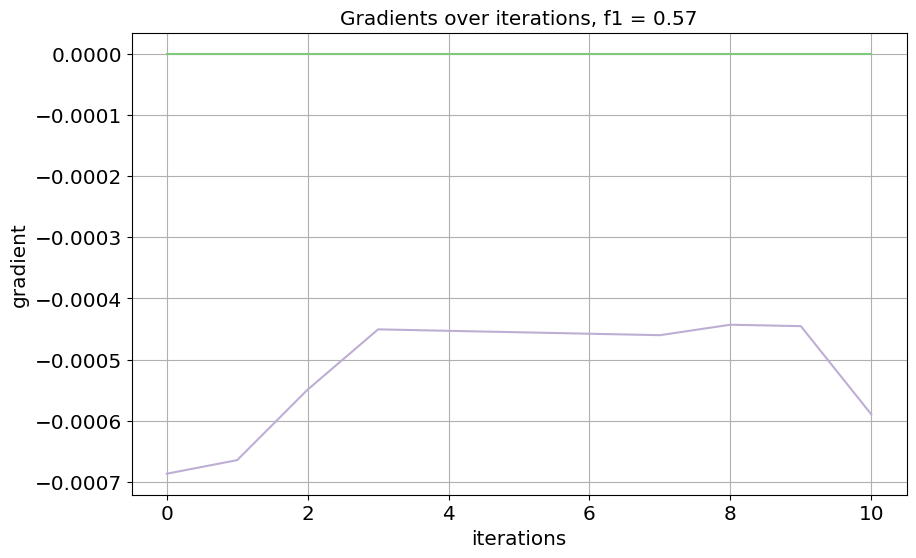

In [51]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

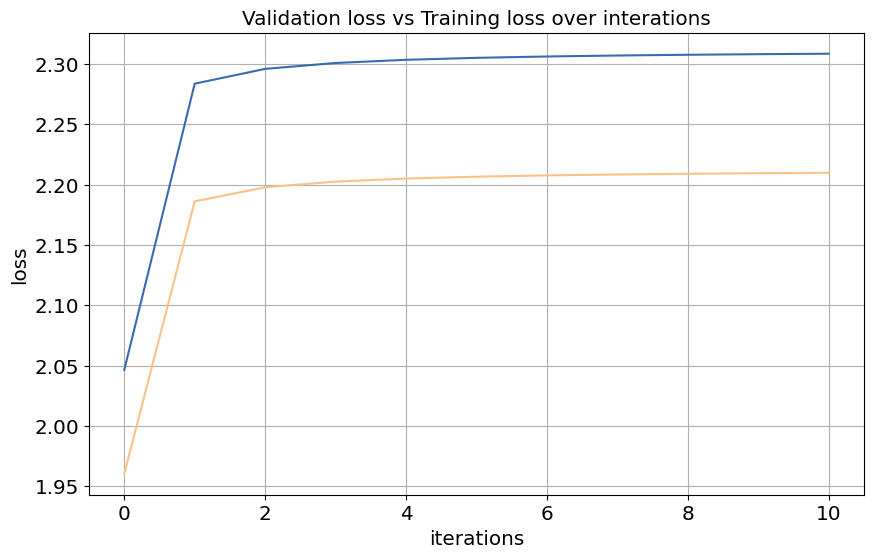

In [33]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [34]:
g_id = 58
i = 0 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

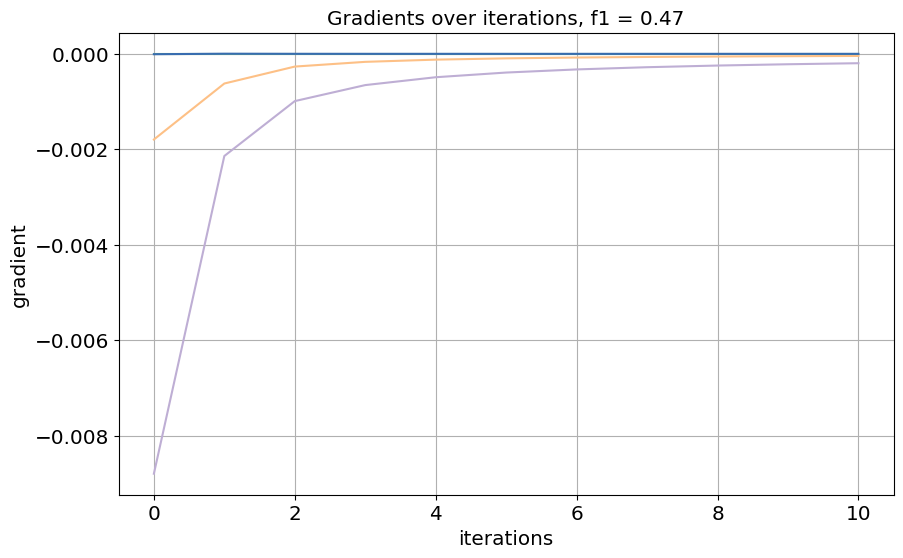

In [35]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

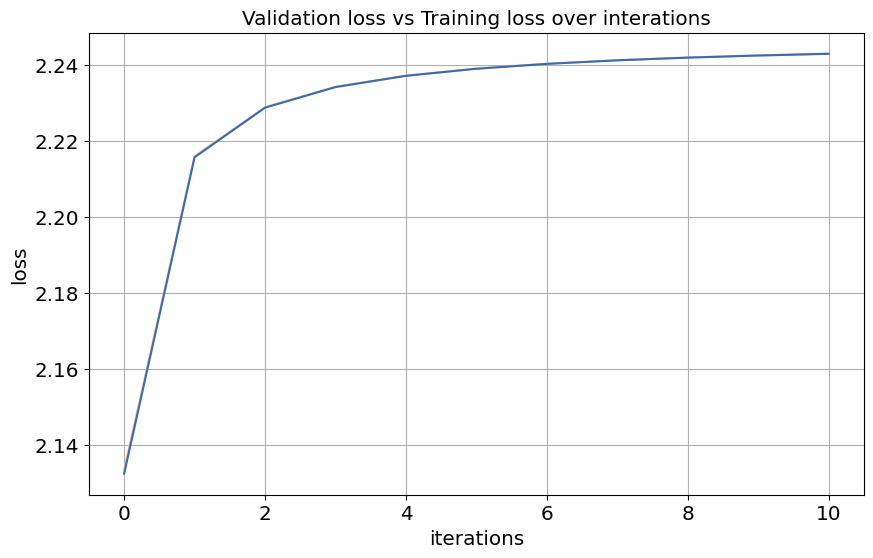

In [36]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [37]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


/tmp/ipykernel_23533/560291286.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


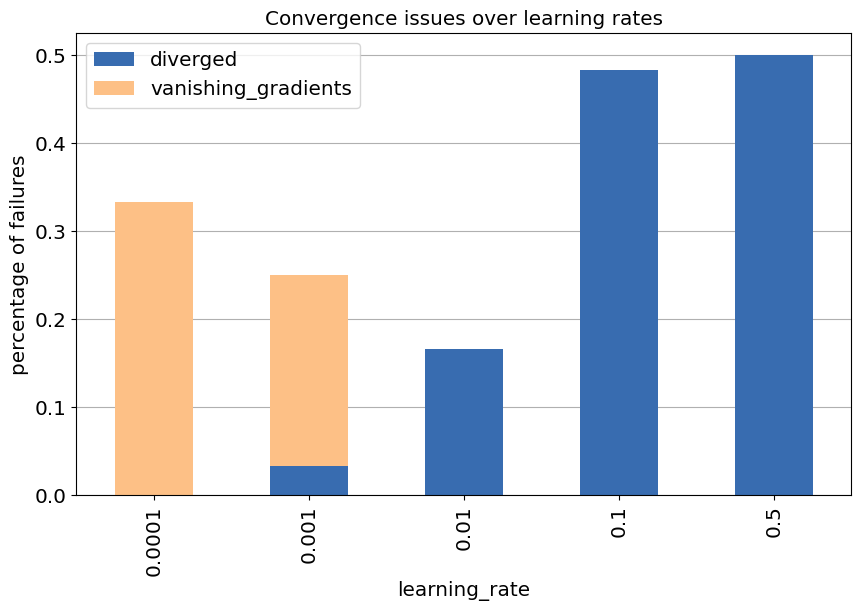

In [38]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
failure_count.plot(ax = ax, kind='bar', stacked=True, cmap=cmap)
ax.set(title=f'Convergence issues over learning rates', ylabel='percentage of failures')
ax.grid(axis='y')

In [39]:
def get_failure_df(model_lists_df, by_col='hidden_layer_sizes'):
    failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
    failure_count = failure_count.reset_index(drop=False)
    failure_count['layer_size_len'] = failure_count[by_col].apply(lambda x: len(x))
    failure_count = failure_count.sort_values(by='layer_size_len')
    failure_count = failure_count.drop('layer_size_len', axis=1)
    failure_count = failure_count.set_index(by_col)
    return failure_count

/tmp/ipykernel_23533/3839886018.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


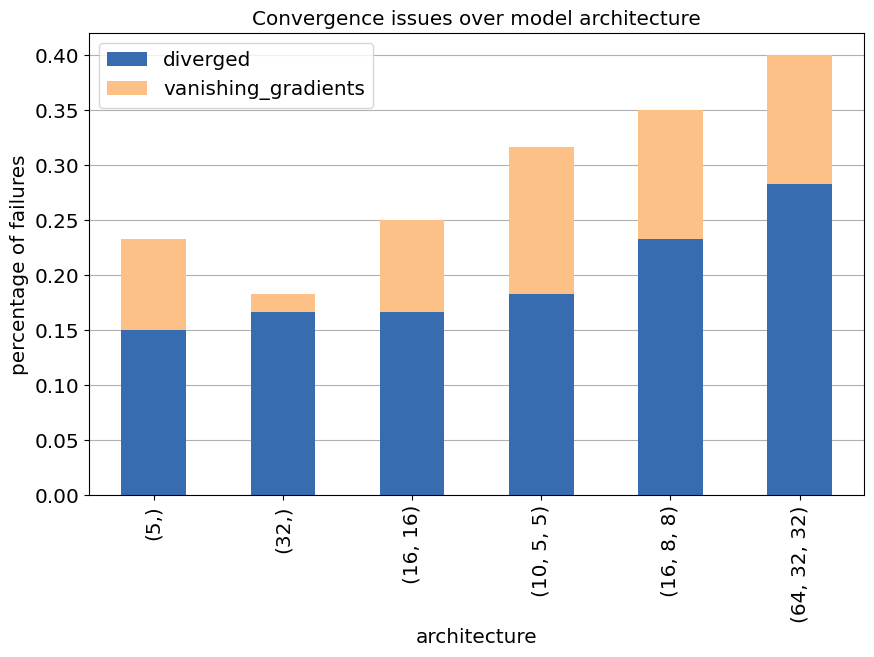

In [40]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = get_failure_df(model_lists_df, by_col='hidden_layer_sizes')
failure_count.plot(ax = ax, kind='bar', stacked=True, colormap=cmap)
ax.set(title=f'Convergence issues over model architecture', ylabel='percentage of failures', xlabel='architecture')
ax.grid(axis='y')